# Data Importation

In [1]:
%reset
import pandas as pd

otu_table = pd.read_csv("/data/namlhs/gmrepo/data"
                        "/modelling/absolute_count_raw.csv",
                        sep='\s+')

tax_table = pd.read_csv("/data/namlhs/gmrepo/data"
                        "/modelling/tax_table.csv",
                        sep=',')

meta_df = pd.read_csv("/data/namlhs/gmrepo/data"
                 "/modelling/total.csv",
                 index_col= 0)

# Data Wrangling

In [2]:
print(otu_table.head())

otu_table.set_index('query_name', inplace = True)
print(otu_table.head())

df =  meta_df[meta_df['associated phenotype'] != 'D000236']

  query_name  GCA_000007325.1  GCA_000020605.1  GCA_000154345.1  \
0  DRR127491                0              533                0   
1  DRR127507                0                0                0   
2  DRR127509                0              273                0   
3  DRR127514                0                0                0   
4  DRR127515                0              226              279   

   GCA_000155435.1  GCA_000158655.1  GCA_000166735.2  GCA_000182945.1  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   GCA_000242235.1  GCA_000283635.1  ...  GCF_902460355.1  GCF_902460545.1  \
0                0                0  ...                0                0   
1 

In [142]:
# #relative abundance
# otu_rel_table = (otu_table.T/otu_table.sum(axis=1)).T
# otu_rel_table.sum(axis=1)

# # pick first 50 ASVs only
# otu_fil = otu_rel_table.iloc[: , :51]

# otu_fil.index = otu_fil.index.str.replace('_', '.')

# otu_fil.index.name = 'run_id'

In [3]:
markers_genus = [
    'g__Fusobacterium',
    'g__Parvimonas'
    ]
markers_species = [
    ]

In [5]:
import numpy as np

#relative abundance
otu_rel_table = (otu_table.T/otu_table.sum(axis=1)).T
otu_rel_table.sum(axis=1)

def create_array(start, end, prefix):
    return np.array([prefix + str(i) for i in range(start, end + 1)])

if __name__ == "__main__":
    top_abund = create_array(1, 50, "ASV")
    lim_abund = create_array(1, 200, "ASV")
    print(top_abund)
    print(lim_abund)
    # Convert NumPy arrays to Python lists
    top_abund_list = top_abund.tolist()
    lim_abund_list = lim_abund.tolist()

# pick most abundance and 
# pick_otu = tax_table[((tax_table['Species'].isin(markers_species)) |
#                       (tax_table['Genus'].isin(markers_genus)) |
#                       (tax_table.index.isin(top_abund))) &
#                      (tax_table.index.isin(lim_abund))].index


pick_otu = tax_table[((tax_table['Species'].isin(markers_species)) |
                      (tax_table['Genus'].isin(markers_genus)) |
                      (tax_table['ASV'].isin(top_abund_list))
                      )]

# print(pick_otu['Ident'].head)

# ident_value = [col for col in pick_otu['Ident'].tolist()]
otu_fil = otu_rel_table.loc[:, otu_rel_table.columns.isin(pick_otu['Ident'])]
# otu_fil.index = otu_fil.index.str.replace('_', '.')

['ASV1' 'ASV2' 'ASV3' 'ASV4' 'ASV5' 'ASV6' 'ASV7' 'ASV8' 'ASV9' 'ASV10'
 'ASV11' 'ASV12' 'ASV13' 'ASV14' 'ASV15' 'ASV16' 'ASV17' 'ASV18' 'ASV19'
 'ASV20' 'ASV21' 'ASV22' 'ASV23' 'ASV24' 'ASV25' 'ASV26' 'ASV27' 'ASV28'
 'ASV29' 'ASV30' 'ASV31' 'ASV32' 'ASV33' 'ASV34' 'ASV35' 'ASV36' 'ASV37'
 'ASV38' 'ASV39' 'ASV40' 'ASV41' 'ASV42' 'ASV43' 'ASV44' 'ASV45' 'ASV46'
 'ASV47' 'ASV48' 'ASV49' 'ASV50']
['ASV1' 'ASV2' 'ASV3' 'ASV4' 'ASV5' 'ASV6' 'ASV7' 'ASV8' 'ASV9' 'ASV10'
 'ASV11' 'ASV12' 'ASV13' 'ASV14' 'ASV15' 'ASV16' 'ASV17' 'ASV18' 'ASV19'
 'ASV20' 'ASV21' 'ASV22' 'ASV23' 'ASV24' 'ASV25' 'ASV26' 'ASV27' 'ASV28'
 'ASV29' 'ASV30' 'ASV31' 'ASV32' 'ASV33' 'ASV34' 'ASV35' 'ASV36' 'ASV37'
 'ASV38' 'ASV39' 'ASV40' 'ASV41' 'ASV42' 'ASV43' 'ASV44' 'ASV45' 'ASV46'
 'ASV47' 'ASV48' 'ASV49' 'ASV50' 'ASV51' 'ASV52' 'ASV53' 'ASV54' 'ASV55'
 'ASV56' 'ASV57' 'ASV58' 'ASV59' 'ASV60' 'ASV61' 'ASV62' 'ASV63' 'ASV64'
 'ASV65' 'ASV66' 'ASV67' 'ASV68' 'ASV69' 'ASV70' 'ASV71' 'ASV72' 'ASV73'
 'ASV74' 'ASV75' 'A

In [145]:
pick_otu['Ident']

77        GCA_000806115.1
223       GCA_001784635.1
250       GCA_001873985.1
358       GCA_002254545.1
1046      GCA_002688965.1
               ...       
397404    GCF_902375195.1
397408    GCF_902375245.1
397474    GCF_902376175.1
397498    GCF_902381645.1
402704    GCF_944739345.1
Name: Ident, Length: 253, dtype: object

In [146]:
#check the data sparsity
sparse = df.isnull().sum()/len(df)
display(sparse)

sparse_filtered = sparse[sparse < 0.2]

# Display the filtered Series
print(sparse_filtered)

#keep only column in sparse_filtered
df_filtered = df.loc[:, sparse_filtered.index]
df_filtered = df_filtered.set_index('run ID')
display(df_filtered)

run ID                  0.000000
experiment type         0.000000
instrument model        0.000000
host age                0.021254
sex                     0.413036
BMI                     0.043925
country                 0.000000
associated phenotype    0.000000
QC status               0.295430
dtype: float64

run ID                  0.000000
experiment type         0.000000
instrument model        0.000000
host age                0.021254
BMI                     0.043925
country                 0.000000
associated phenotype    0.000000
dtype: float64


,experiment type,instrument model,host age,BMI,country,associated phenotype
run ID,,,,,,
ERR478958,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478959,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478960,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478961,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478962,Metagenomics,Illumina,53.0,32.0,France,D006262
...,...,...,...,...,...,...
ERR1293933,Metagenomics,Illumina,62.0,25.8,USA,D006262
ERR1293934,Metagenomics,Illumina,84.0,23.5,USA,D015179
ERR1293935,Metagenomics,Illumina,84.0,23.5,USA,D015179


In [147]:
df_filtered.rename(columns={'associated phenotype': 'associated_phenotype'}, inplace=True)
df_crc = df_filtered[['associated_phenotype']].copy()


df_crc.index.name = 'run_id'

len(df_crc)
print(otu_fil.head())


            GCA_000007325.1  GCA_000020605.1  GCA_000154345.1  \
query_name                                                      
DRR127491               NaN              NaN              NaN   
DRR127507               NaN              NaN              NaN   
DRR127509               NaN              NaN              NaN   
DRR127514               NaN              NaN              NaN   
DRR127515               NaN              NaN              NaN   

            GCA_000155435.1  GCA_000158655.1  GCA_000166735.2  \
query_name                                                      
DRR127491               NaN              NaN              NaN   
DRR127507               NaN              NaN              NaN   
DRR127509               NaN              NaN              NaN   
DRR127514               NaN              NaN              NaN   
DRR127515               NaN              NaN              NaN   

            GCA_000182945.1  GCA_000242235.1  GCA_000283635.1  \
query_name             

In [ ]:
#merge first 50 ASVs relative abundance
match_df = pd.merge(df_crc, otu_fil, left_index=True, right_index=True)

df_cor = match_df.iloc[:, 1:].corr(method='kendall')
df_pairs = df_cor.unstack()

# print(df_pairs)
sorted_pairs = df_pairs.sort_values(kind='quicksort')
remove_pairs = sorted_pairs[(abs(sorted_pairs) >= 0.5) & (sorted_pairs != 1)]

display(remove_pairs)

Series([], dtype: float64)

In [ ]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

X = match_df.drop(columns ='associated_phenotype')

y = match_df.associated_phenotype
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale
scaler = StandardScaler()
scaler.fit(X_train)

X_scale = scaler.transform(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logreg = LogisticRegression(random_state=777, 
                            max_iter= 100000, 
                            class_weight= 'balanced',
                            penalty="elasticnet", 
                            solver="saga",
                            C=1000,
                            l1_ratio=0.15,
                            )

lr_train = logreg.fit(X_train, y_train)
y_pred = lr_train.predict(X_test)

/home/namlhs/anaconda3/envs/gmrepo/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
/home/namlhs/anaconda3/envs/gmrepo/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
/home/namlhs/anaconda3/envs/gmrepo/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

,factors,coef
16,GCF_900637905.1,6.024630
2,GCF_000158275.2,5.245705
6,GCF_000235465.1,2.835289
8,GCF_001457555.1,1.924059
0,GCA_000007325.1,1.535990
7,GCF_000493815.1,0.941662
9,GCF_002573625.1,0.801368
14,GCF_016552165.1,0.750666
1,GCA_000182945.1,0.424550
13,GCF_014217355.1,0.209339


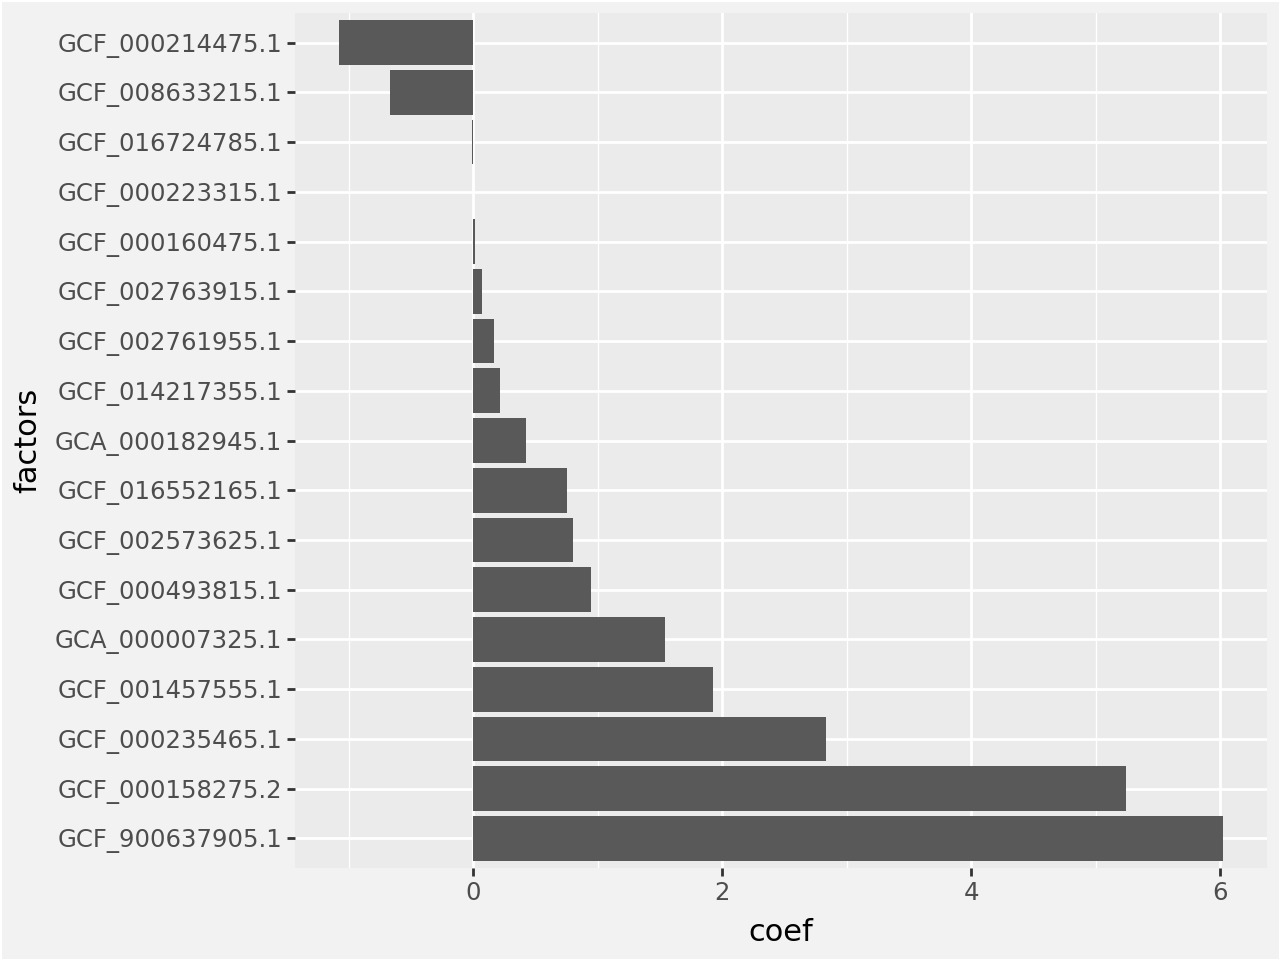

In [ ]:
import plotnine as p9

# get the feature coefficients and feature names
feature_coef = lr_train.coef_[0]
feature_names = X.columns.tolist() # assuming your input data is a pandas DataFrame

coef_df = pd.DataFrame({'factors':feature_names, 'coef':feature_coef}).sort_values(ascending=False, by="coef")
display(coef_df)

#sorted factor
factor_list = coef_df['factors']

(
    p9.ggplot(coef_df, p9.aes(x = 'factors', y = 'coef')) +
    p9.geom_col() +
    p9.scale_x_discrete(limits = factor_list) +
    p9.coord_flip()
)	

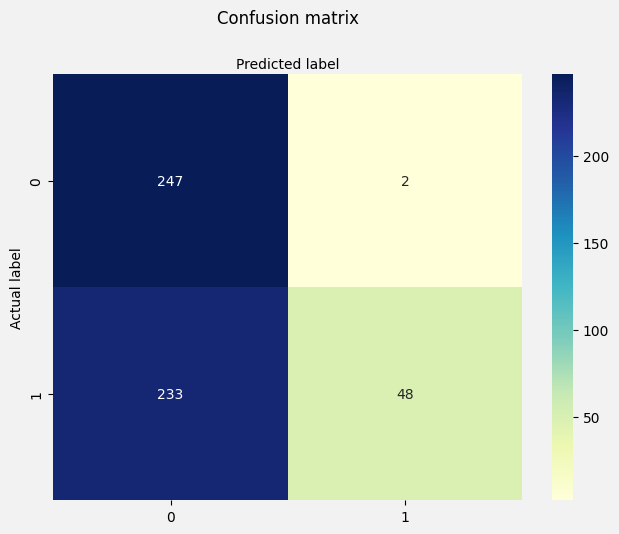

In [ ]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# Visualize
# import required modules
import numpy as np
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.rcParams['figure.facecolor'] = '#f2f2f2'
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Healthy', 'CRC']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.51      0.99      0.68       249
         CRC       0.96      0.17      0.29       281

    accuracy                           0.56       530
   macro avg       0.74      0.58      0.48       530
weighted avg       0.75      0.56      0.47       530

